No existing weights found. Training from scratch.
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.4075
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1864
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0454
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0429
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0561
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0228
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0208
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0277
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0290
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0207
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0155
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0137
Epoch 13/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0143
Epoch 14/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0131
Epoch 15/100
2/2 ━━━━━━━━━━━━━━━━━━

Results saved to trackingresults.csv


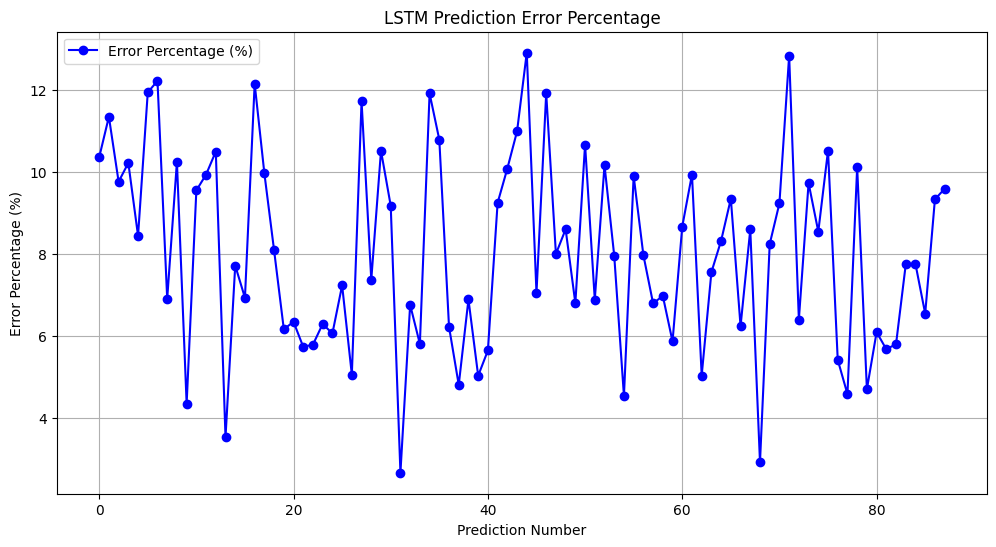

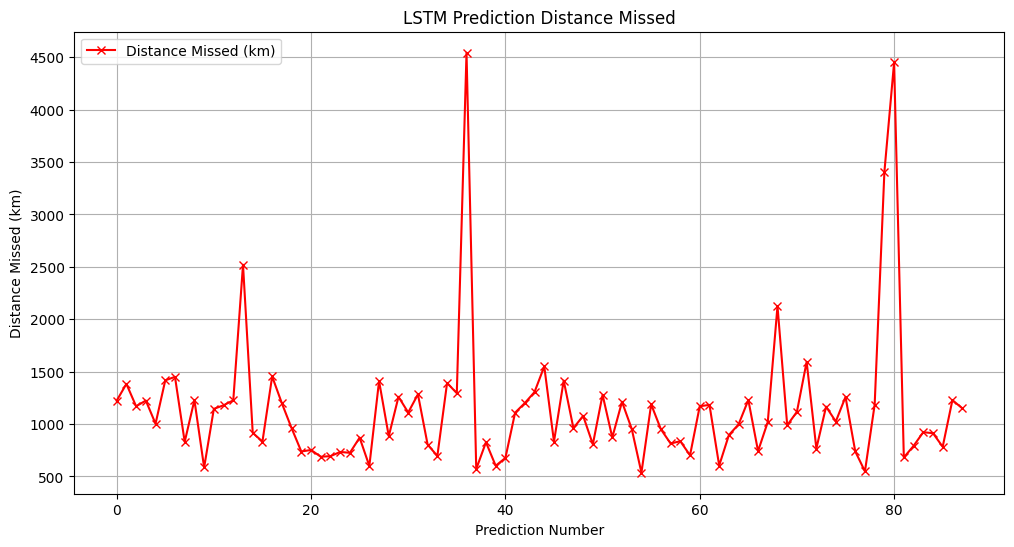

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from tensorflow import keras
from tensorflow.keras import layers, Input
from sklearn.preprocessing import MinMaxScaler
from sgp4.api import Satrec
from sgp4.conveniences import jday
from datetime import datetime, timezone, timedelta
import pandas as pd
import tkinter as tk
from tkinter import filedialog, messagebox
import os
import random
import plotly.graph_objs as go
import plotly.io as pio

# ================================
# Read TLE data from file
# ================================
def read_tle_from_txt(filename, num_samples):
    try:
        with open(filename, "r") as file:
            lines = file.readlines()
        
        tle_data = []
        for i in range(len(lines)):
            if "1 " in lines[i] and i + 1 < len(lines) and "2 " in lines[i + 1]:
                tle_data.append((lines[i - 1].strip(), lines[i].strip(), lines[i + 1].strip()))
        
        if len(tle_data) > num_samples:
            tle_data = random.sample(tle_data, num_samples)
        
        return tle_data
    
    except FileNotFoundError:
        print(f"Benchmark file {filename} not found.")
        return None

# ================================
# Build LSTM Model (Fixed)
# ================================
def build_lstm_model():
    model = keras.Sequential([
        Input(shape=(10, 3)),  
        layers.LSTM(128, return_sequences=True, stateful=False),  
        layers.Dropout(0.2),
        layers.LSTM(128, return_sequences=False, stateful=False),
        layers.Dropout(0.2),
        layers.Dense(3)
    ])
    
    model.compile(optimizer='adam', loss='mse')
    return model

# ================================
# Get satellite position and velocity
# ================================
def get_position_velocity(satellite, date_time):
    jd, fr = jday(date_time.year, date_time.month, date_time.day,
                  date_time.hour, date_time.minute, date_time.second + date_time.microsecond * 1e-6)
    e, r, v = satellite.sgp4(jd, fr)
    return np.array(r, dtype=np.float32) if e == 0 else None

# ================================
# Generate Benchmark Positions
# ================================
def generate_benchmark_positions(filename, num_samples, num_points=10):
    benchmark_tles = read_tle_from_txt(filename, num_samples)
    if not benchmark_tles:
        return np.array([]), np.array([])

    positions = []
    for name, tle1, tle2 in benchmark_tles:
        satellite = Satrec.twoline2rv(tle1, tle2)
        start_time = datetime.now(timezone.utc)
        sequence = []

        for i in range(num_points):
            date_time = start_time + timedelta(seconds=i * 10)
            position = get_position_velocity(satellite, date_time)
            if position is not None:
                sequence.append(position)

        if len(sequence) == num_points:
            positions.append(sequence)

    if not positions:
        return np.array([]), np.array([])

    positions = np.array(positions)
    return positions[:, :, 0], positions[:, :, 1], positions[:, :, 2]

# ================================
# Train the LSTM Model (Fixed)
# ================================
def train_lstm_model(model, positions, epochs, batch_size):
    scaler = MinMaxScaler()
    num_sequences = positions.shape[0]
    positions_reshaped = positions.reshape(num_sequences * 10, 3)

    # Fitting the scaler (fixing the "MinMaxScaler not fitted" error)
    positions_scaled = scaler.fit_transform(positions_reshaped).reshape(num_sequences, 10, 3)

    positions_scaled += np.random.normal(0, 0.001, positions_scaled.shape)

    X, y = positions_scaled[:, :-1, :], positions_scaled[:, -1, :]

    if X.shape[0] == 0:
        print("Not enough data for LSTM training.")
        return None, scaler

    history = model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=1)

    model.save_weights("lstm_weights.weights.h5")
    print("Model weights saved.")

    return model, scaler

# ================================
# Load existing weights (Fixed)
# ================================
def load_existing_weights(model):
    if os.path.exists("lstm_weights.h5"):
        model.load_weights("lstm_weights.h5")
        print("Loaded existing model weights.")
    else:
        print("No existing weights found. Training from scratch.")

# Converting ECEF to lat/lon
def ecef_to_latlon(x, y, z):
    lon = np.arctan2(y, x) * (180 / np.pi)
    hyp = np.sqrt(x**2 + y**2)
    lat = np.arctan2(z, hyp) * (180 / np.pi)
    return lat, lon

# Function to make 3d interactive plot of earth 
def plot_results(benchmark_positions, predictions):
    benchmark_latlon = np.array([ecef_to_latlon(x, y, z) for x, y, z in benchmark_positions[:, -1, :]])
    predicted_latlon = np.array([ecef_to_latlon(x, y, z) for x, y, z in predictions])

    fig = go.Figure()

    # Adding Earth's surface using a globe texture
    lats = np.linspace(-90, 90, 180)
    lons = np.linspace(-180, 180, 360)
    lon_grid, lat_grid = np.meshgrid(lons, lats)
    earth_radius = 6371  # Earth radius in km

    # Converting lat/lon to ECEF
    x = earth_radius * np.cos(np.radians(lat_grid)) * np.cos(np.radians(lon_grid))
    y = earth_radius * np.cos(np.radians(lat_grid)) * np.sin(np.radians(lon_grid))
    z = earth_radius * np.sin(np.radians(lat_grid))

    fig.add_trace(
        go.Surface(
            x=x,
            y=y,
            z=z,
            colorscale='earth',
            opacity=0.7 
        )
    )

    # Plotting benchmark positions
    fig.add_trace(
        go.Scatter3d(
            x=benchmark_positions[:, -1, 0],
            y=benchmark_positions[:, -1, 1],
            z=benchmark_positions[:, -1, 2],
            mode='markers',
            marker=dict(size=4, color='blue'),
            name='Benchmark'
        )
    )

    # Plotting predicted positions
    fig.add_trace(
        go.Scatter3d(
            x=predictions[:, 0],
            y=predictions[:, 1],
            z=predictions[:, 2],
            mode='markers',
            marker=dict(size=4, color='orange'),
            name='Prediction'
        )
    )

    # Layout adjustments
    fig.update_layout(
        title="LSTM Satellite Tracking Prediction",
        scene=dict(
            xaxis=dict(visible=False),
            yaxis=dict(visible=False),
            zaxis=dict(visible=False),
            aspectmode='auto'
        ),
        margin=dict(l=0, r=0, b=0, t=30)
    )

    fig.show() # Displaying plot


# Function to save results of each real position (lat & lon) of a satellite, the LSTM's prediction 
# of the satellite's real position (lat & lon), and the error in that prediction measured by MSE
def save_results_to_csv(benchmark_positions, predictions, filename="trackingresults.csv"):
    # Flatten benchmark positions and predictions to make saving easier
    benchmark_flat = benchmark_positions[:, -1, :].reshape(-1, 3)
    predictions_flat = predictions.reshape(-1, 3)

    # Calculating RMSE for each row
    rmse = np.sqrt(((benchmark_flat - predictions_flat) ** 2).mean(axis=1))

    # Creating a DataFrame with benchmark and predicted points
    df = pd.DataFrame({
        'Benchmark Lattitude': benchmark_flat[:, 0],
        'Benchmark Longitude': benchmark_flat[:, 1],
        'Benchmark Altitude': benchmark_flat[:, 2],
        'Predicted Lattitude': predictions_flat[:, 0],
        'Predicted Longitude': predictions_flat[:, 1],
        'Predicted Altitude': predictions_flat[:, 2],
        'Error': rmse # gives error of each point
    })

    # Saving to CSV 
    df.to_csv(filename, index=False)
    print(f"Results saved to {filename}")

def display_error_chart(filename="trackingresults.csv"):
    try:
        # Read the CSV file
        df = pd.read_csv(filename)
        
        # Calculate distance missed in km using Euclidean distance formula
        df['Distance Missed (km)'] = np.sqrt(
            (df['Benchmark Lattitude'] - df['Predicted Lattitude'])**2 +
            (df['Benchmark Longitude'] - df['Predicted Longitude'])**2 +
            (df['Benchmark Altitude'] - df['Predicted Altitude'])**2
        )

        # Calculate error percentage (based on latitude/longitude/altitude)
        df['Error Percentage'] = (df['Error'] / np.sqrt(
            df['Benchmark Lattitude']**2 +
            df['Benchmark Longitude']**2 +
            df['Benchmark Altitude']**2
        )) * 100

        # Plot error percentage
        plt.figure(figsize=(12, 6))
        plt.plot(df.index, df['Error Percentage'], label='Error Percentage (%)', color='blue', marker='o')
        plt.xlabel('Prediction Number')
        plt.ylabel('Error Percentage (%)')
        plt.title('LSTM Prediction Error Percentage')
        plt.legend()
        plt.grid()

        # Plot distance missed
        plt.figure(figsize=(12, 6))
        plt.plot(df.index, df['Distance Missed (km)'], label='Distance Missed (km)', color='red', marker='x')
        plt.xlabel('Prediction Number')
        plt.ylabel('Distance Missed (km)')
        plt.title('LSTM Prediction Distance Missed')
        plt.legend()
        plt.grid()

        # Show the plots
        plt.show()

    except Exception as e:
        print(f"Error generating chart: {e}")

# ================================
# GUI Setup (Fixed)
# ================================
def run_gui():
    def start_prediction(event=None):
        filename = filedialog.askopenfilename(title="Select TLE File")
        if not filename:
            messagebox.showerror("Error", "No file selected")
            return

        try:
            num_samples = int(sample_entry.get())
            epochs = int(epoch_entry.get())
            batch_size = int(batch_entry.get())

            benchmark_x, benchmark_y, benchmark_z = generate_benchmark_positions(filename, num_samples)
            benchmark_positions = np.stack((benchmark_x, benchmark_y, benchmark_z), axis=-1)

            model = build_lstm_model()
            load_existing_weights(model)

            model, scaler = train_lstm_model(model, benchmark_positions, epochs, batch_size)

            positions_scaled = scaler.transform(benchmark_positions.reshape(-1, 3)).reshape(benchmark_positions.shape)
            predictions = model.predict(positions_scaled[:, :-1, :])
            predictions = scaler.inverse_transform(predictions)

            print("Predictions complete.")
            
            # ✅ Save to Cesium JSON
            save_predictions_for_cesium(predictions)  # <<< INSERT THIS NEW FUNCTION CALL
            
            # ✅ Plot the results
            plot_results(benchmark_positions, predictions)
            
            # ✅ Save results to CSV
            save_results_to_csv(benchmark_positions, predictions)

            
            display_error_chart()

        except Exception as e:
                messagebox.showerror("Error", str(e))

    
    root = tk.Tk()
    root.title("Satellite Tracker")

    tk.Label(root, text="Number of Samples:").grid(row=0, column=0)
    sample_entry = tk.Entry(root)
    sample_entry.grid(row=0, column=1)

    tk.Label(root, text="Epochs:").grid(row=1, column=0)
    epoch_entry = tk.Entry(root)
    epoch_entry.grid(row=1, column=1)

    tk.Label(root, text="Batch Size:").grid(row=2, column=0)
    batch_entry = tk.Entry(root)
    batch_entry.grid(row=2, column=1)

    tk.Button(root, text="Start Prediction", command=start_prediction).grid(row=3, column=0, columnspan=2)

    # Trigger start with "Enter" key
    root.bind('<Return>', start_prediction)

    root.mainloop()

# ================================
# Run the GUI
# ================================
if __name__ == "__main__":
    run_gui()



# OUTSIDE run_gui() !
import json

def save_predictions_for_cesium(predictions, filename="predictions.json"):
    output = []
    for idx, (x, y, z) in enumerate(predictions):
        output.append({
            "id": f"Satellite {idx+1}",
            "position": {"x": float(x), "y": float(y), "z": float(z)}
        })
    with open(filename, "w") as f:
        json.dump(output, f, indent=4)
    print(f"Predictions saved for Cesium in {filename}")

def run_gui():
    def start_prediction(event=None):
        # Do prediction
        save_predictions_for_cesium(predictions)   # ✅ CALL here
        # Other code...

    # GUI setup code...
    root.mainloop()
